<H2>Common Model Preparation</H2>
<p>Implement sklearn-kit as core libraries. The models built in this way will be save for using in future application.</p>
<p>Any data can be applied to this code as long as it contains TEAMRESULT as predictor</p> 
<p>while the rest parameters must be integer or float</p>

<H2>List of utility functions</H2>
<H3><B>  create_min_max_range(DataFram, Column_name)  </B></H3> <br>
<B> Arguments: </B> DataFrame(Pandas.dataframe), Column_name (String) <br>
<i>Find min,max of specific column on input data frame. Output will be tuple of [min,max]. <br>
If data is not number, output will be [0,0] </i>

<H3><B>  plot_c_matrix(predict, actual )  </B></H3> <br>
<B> Arguments: </B> predict(np.array),actual result(np.array) <br>
<i> plot confuse matrix base on prediction to actual result. Value 0 mean lose, 1 mean win </i>


In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn import linear_model
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats
import seaborn

In [2]:
#utilities functions

# team result = (0,1) or (lose,win)
team_result_meta = ['Lose','Win']
%matplotlib inline

""" Min max calculation function : for neural lab """
def create_min_max_range(dataframe, column_name):
    # check if column is not string
    if(dataframe[column_name].dtype == np.float64 or dataframe[column_name].dtype == np.int64):
        return [round(dataframe[column_name].min(),6), round(dataframe[column_name].max(),6)]
    else:
        #return 0,0 as string
        return [0,0]

""" Confusion matrix plot """
def plot_c_matrix(predict, actual):
    %matplotlib inline
    cm = confusion_matrix(actual, predict)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print cm
    plt.imshow(cm , interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(team_result_meta))
    plt.xticks(tick_marks, team_result_meta)
    plt.yticks(tick_marks, team_result_meta)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
#display configure
np.set_printoptions(precision=4)


<h3><b>Load csv data</b></h3> 
<i>Match data, basically data consists of two teams (A,B) with match result <br> 
0 for A lose and 1 for 1 win. All data can be used in model building</i>


In [16]:
test_ratio = 0.2
df = pd.read_csv('train_data_x1.csv',header=0)
vdf = pd.read_csv('train_data_x2.csv', header=0)
print df.columns
print vdf.columns

Index([u'TEAMRESULT', u'A_PCT', u'A_RPI', u'A_PCT_NC', u'A_RPI_NC',
       u'A_RANK_NC', u'A_PCT_C', u'A_RPI_C', u'A_RANK_C', u'A_ROAD', u'A_NC',
       u'A_OPP', u'A_WIN_F', u'A_LOST_F', u'A_WL_1_25', u'A_WL_26_50',
       u'A_WL_51_100', u'A_WL_101_200', u'A_WL_201', u'A_ND1', u'B_PCT',
       u'B_RPI', u'B_PCT_NC', u'B_RPI_NC', u'B_RANK_NC', u'B_PCT_C',
       u'B_RPI_C', u'B_RANK_C', u'B_ROAD', u'B_NC', u'B_OPP', u'B_WIN_F',
       u'B_LOST_F', u'B_WL_1_25', u'B_WL_26_50', u'B_WL_51_100',
       u'B_WL_101_200', u'B_WL_201', u'B_ND1', u'PLAYIN_FLAG', u'RD1_WIN',
       u'RD2_WIN', u'RD3_WIN', u'RD4_WIN', u'RD5_WIN', u'RD6_WIN', u'RD7_WIN',
       u'TEAM_RATING', u'TEAM_SEED', u'PLAYIN_FLAG_1', u'RD1_WIN_1',
       u'RD2_WIN_1', u'RD3_WIN_1', u'RD4_WIN_1', u'RD5_WIN_1', u'RD6_WIN_1',
       u'RD7_WIN_1', u'TEAM_RATING_1', u'TEAM_SEED_1'],
      dtype='object')
Index([u'TEAMRESULT', u'RK', u'SEED', u'S16', u'E8', u'FF', u'NC', u'W_SIM',
       u'CURRENTWINPCT', u'OVERALLWINPCT', u'RK

### Data Analysis
We want to know if there are some different between.
1. team result ~ win percentage of team A and B.
2. team result ~ team rating of A and B.

_Negative value mean team A has lower games stat than B_

From output, team rating, win percentage and rpi are related to match result.

It's obvious because win percentage, rpi and team rating are calculated from regular season matches.

Basically, it inherits from match results. So using these data are actually pointless.

It's more like we use full regular season stat to predict that regular season match.

To improve it, the approach could be
1. Use regular season 2015-2016 data, train with matches from playoff 2015-2016, Get model
2. Use that model with regular season 2016-2017 to predict playoff result for 2016-2017

In [17]:
df2 = df
df2['win_pct_diff'] = df['A_PCT'] - df['B_PCT']
df2['rpi_diff'] = df['A_RPI'] - df['B_RPI']
df2['team_rating_diff'] = df['TEAM_RATING'] - df['TEAM_RATING_1']
df2.groupby('TEAMRESULT').mean()[['win_pct_diff','rpi_diff','team_rating_diff']]

,win_pct_diff,rpi_diff,team_rating_diff
TEAMRESULT,,,
0,-0.035529,-0.019347,-2.199742
1,0.035529,0.019347,2.199742


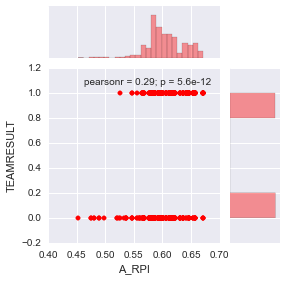

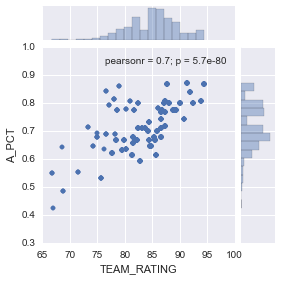

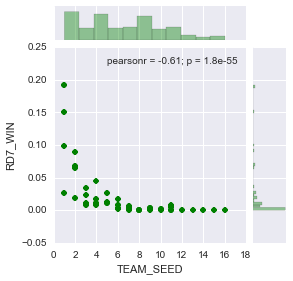

In [56]:
#plot some scatter

plt.clf()
ax1 = seaborn.jointplot(x='A_RPI', y='TEAMRESULT', color='r', data=df, size=4, ratio=3)
ax2 = seaborn.jointplot(x='TEAM_RATING', y='A_PCT', data=df, size=4)
ax3 = seaborn.jointplot(x='TEAM_SEED', y='RD7_WIN', color='g', data=df, size=4)

### Variables analysis

First we input all variable into f_regression function to analysis f-score and p-value of each variables.


In [57]:
#variables selection
#all variables selections
#formula = ' + '.join(df.columns[1:])

y, X = dmatrices('TEAMRESULT ~ A_PCT + A_RPI + A_PCT_NC + A_RPI_NC + A_RANK_NC + A_PCT_C + A_RPI_C + \
                A_RANK_C + A_ROAD + A_NC + A_OPP + A_WIN_F + A_LOST_F + A_WL_1_25 + A_WL_26_50 + A_WL_51_100 + \
                A_WL_101_200 + A_WL_201 + A_ND1 + B_PCT + B_RPI + B_PCT_NC + B_RPI_NC + B_RANK_NC + B_PCT_C + \
                B_RPI_C + B_RANK_C + B_ROAD + B_NC + B_OPP + B_WIN_F + B_LOST_F + B_WL_1_25 + B_WL_26_50 + \
                B_WL_51_100 + B_WL_101_200 + B_WL_201 + B_ND1 + PLAYIN_FLAG + RD1_WIN + RD2_WIN + RD3_WIN + \
                RD4_WIN + RD5_WIN + RD6_WIN + RD7_WIN + TEAM_RATING + TEAM_SEED + PLAYIN_FLAG_1 + RD1_WIN_1 + \
                RD2_WIN_1 + RD3_WIN_1 + RD4_WIN_1 + RD5_WIN_1 + RD6_WIN_1 + RD7_WIN_1 + TEAM_RATING_1 + \
                TEAM_SEED_1 + win_pct_diff + rpi_diff + team_rating_diff - 1',
                df, return_type='dataframe')
y = np.ravel(y)

In [58]:
#calculate correlation for x1 data which has many variables
#corr = df.corr().abs()
#remove lower out
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
#corr = corr * mask

from sklearn.feature_selection import f_regression
In = X
Expect = y

f_scores_x1 = f_regression(In, Expect)
final = sorted(zip(f_scores_x1[0],f_scores_x1[1], X.columns), reverse=True)

for m,n,o in final:
    print '%s\t\t%.4f\t\t%.4f' % (o,m,n)

rpi_diff		118.1255		0.0000
team_rating_diff		68.2620		0.0000
A_RPI		49.6581		0.0000
B_RPI		49.6581		0.0000
win_pct_diff		49.6511		0.0000
A_RPI_C		44.2083		0.0000
B_RPI_C		44.2083		0.0000
TEAM_SEED_1		43.7271		0.0000
TEAM_SEED		43.7271		0.0000
B_WIN_F		42.5354		0.0000
A_WIN_F		42.5354		0.0000
B_WL_26_50		39.6513		0.0000
A_WL_26_50		39.6513		0.0000
B_WL_1_25		38.5298		0.0000
A_WL_1_25		38.5298		0.0000
B_RANK_C		36.6844		0.0000
A_RANK_C		36.6844		0.0000
RD2_WIN		32.8307		0.0000
RD2_WIN_1		32.8307		0.0000
RD3_WIN_1		32.2652		0.0000
RD3_WIN		32.2652		0.0000
A_RPI_NC		31.4592		0.0000
B_RPI_NC		31.4592		0.0000
TEAM_RATING		28.9207		0.0000
TEAM_RATING_1		28.9207		0.0000
RD4_WIN_1		27.1343		0.0000
RD4_WIN		27.1343		0.0000
A_PCT		27.0300		0.0000
B_PCT		27.0300		0.0000
B_RANK_NC		26.6531		0.0000
A_RANK_NC		26.6531		0.0000
A_OPP		22.6906		0.0000
B_OPP		22.6906		0.0000
RD5_WIN		21.9996		0.0000
RD5_WIN_1		21.9996		0.0000
A_PCT_NC		21.9741		0.0000
B_PCT_NC		21.9741		0.0000
B_WL_51_100		21.2590		0.000

#### On X1 variables p-value

From F-scores and P-Value,

    rpi_diff		118.1255		0.0000

    team_rating_diff		68.2620		0.0000

    A_RPI		49.6581		0.0000

    B_RPI		49.6581		0.0000

    win_pct_diff		49.6511		0.0000

    A_RPI_C		44.2083		0.0000

    B_RPI_C		44.2083		0.0000

    TEAM_SEED_1		43.7271		0.0000

    TEAM_SEED		43.7271		0.0000

    B_WIN_F		42.5354		0.0000

    A_WIN_F		42.5354		0.0000

In [59]:
y, X = dmatrices('TEAMRESULT ~ rpi_diff + team_rating_diff + A_RPI + B_RPI + win_pct_diff +\
                A_RPI_C + B_RPI_C + TEAM_SEED_1 + TEAM_SEED + B_WIN_F + A_WIN_F - 1',
                df, return_type='dataframe')
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)

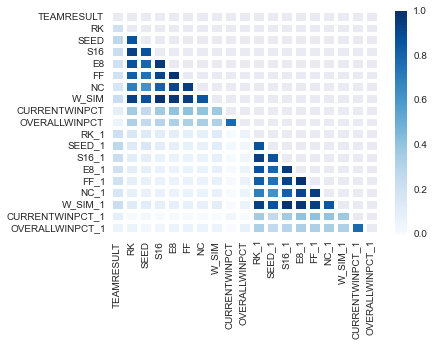

In [60]:
# X2 data calculate correlation and plot it out as heatmap with seasborn
corr = vdf.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr, cmap='Blues', vmax=1.0, vmin=0.0 , mask = mask, linewidths=3)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

<h4>On X2 Correlation</h4>
On x2 data, Kind of obvious result, most of variables related to each other. very high correlation on 
1. RK - S16
2. RK- W_SIM
3. S16 - W_SIM
4. S16 - E8
5. E8 - FF
6. FF - NC
These also applied for second team variables, 
It's reasonable, 
- if team has high win percentage, it's more likely that team will pass each round. 
- if team has higher percentage to pass first round, it's noramlly that it will has higher for next round
So we can either remove all variables except W_SIM for each team it could be enough.

In [9]:
""" 
Prepare column name that will be used in neural network modeling. 
All column in data frame will be used. Any string column will be removed from data frame
"""
#create list of processing columns
headers = list(X_train.columns.values)
neural_axis = []
#apply min max function
for header in headers:
    neural_axis.append(create_min_max_range(X_train, header))


<H3>Logistic Regression</H3>
<p></p>

model accuracy(train):  0.70207852194
model accuracy(test):  0.770642201835
model params:  Index([u'rpi_diff', u'team_rating_diff', u'A_RPI', u'B_RPI', u'win_pct_diff',
       u'A_RPI_C', u'B_RPI_C', u'TEAM_SEED_1', u'TEAM_SEED', u'B_WIN_F',
       u'A_WIN_F'],
      dtype='object')
rpi_diff => 0.000000
team_rating_diff => -0.086700
A_RPI => 0.000000
B_RPI => 0.000000
win_pct_diff => 3.724266
A_RPI_C => 0.093100
B_RPI_C => 0.000000
TEAM_SEED_1 => 0.061346
TEAM_SEED => -0.092372
B_WIN_F => 0.023859
A_WIN_F => -0.022004
==== validation =====
[[54 16]
 [ 9 30]]


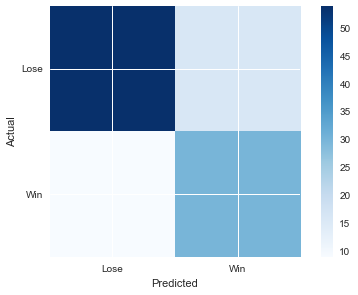

In [61]:
#logistic regression on train data set
model = linear_model.LogisticRegression(C=10, penalty='l1')
model = model.fit(X_train,y_train)

#predict
y_predicted = model.predict(X_test)
y_predicted_proba = model.predict_proba(X_test)

print 'model accuracy(train): ', model.score(X_train, y_train)
print 'model accuracy(test): ', model.score(X_test,y_test)
print 'model params: ', X_train.columns
for vr,vl in zip(X.columns,np.ravel(np.transpose(model.coef_))): 
    print '%s => %.6f' % (vr,vl)
print '==== validation ====='
plot_c_matrix(y_predicted, y_test)

best threshold: 0.530 with score:  0.7890


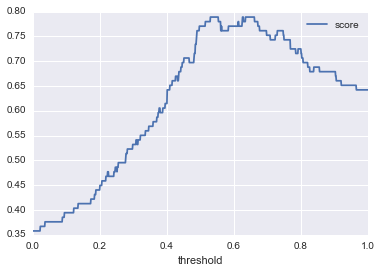

In [62]:
# find cut off threshold by brute force
accuracy = pd.DataFrame(columns=('threshold','score'))

best_predicted = []
best_score = 0.00
best_threshold = 0.00

for i in range(0,1001):
    ratio = i/1000.00
    #focus on win
    y_predicted_new = (y_predicted_proba[:,1] > ratio).astype(np.float)
    score = metrics.accuracy_score(y_test, y_predicted_new)
    accuracy.loc[i] = [ratio, score]
    if score > best_score:
        best_score, best_predicted, best_threshold = score, y_predicted_new, ratio
        

%matplotlib inline
print 'best threshold: %.3f with score:  %.4f' % (best_threshold, best_score)
accuracy.plot(x='threshold', y='score')

[[57 13]
 [10 29]]


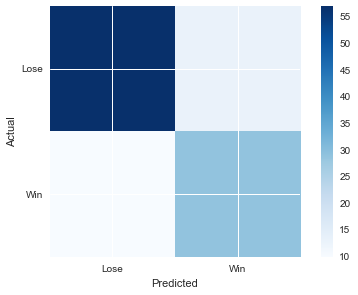

In [63]:
#new confuse matrix
plot_c_matrix(best_predicted, y_test)

decision tree accuracy(train):  0.898383371824
decision accuracy(test):  0.532110091743
====== Parameters analysis ========
rpi_diff	0.3773
team_rating_diff	0.1814
B_WIN_F	0.0697
A_RPI	0.0678
A_RPI_C	0.0638
A_WIN_F	0.0614
win_pct_diff	0.0520
TEAM_SEED	0.0507
B_RPI_C	0.0400
TEAM_SEED_1	0.0208
B_RPI	0.0152
==== validation =====
[[35 35]
 [16 23]]


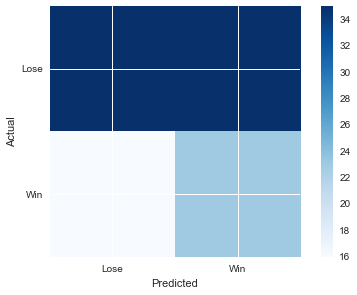

In [64]:
#decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)


#predict
y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

print 'decision tree accuracy(train): ', clf.score(X_train, y_train)
print 'decision accuracy(test): ', clf.score(X_test,y_test)
print '====== Parameters analysis ========'
for x,y in sorted(zip(X_train.columns, map(lambda x: round(x, 4), clf.feature_importances_)), 
             reverse=True,key=lambda tup: tup[1]):
    print '%s\t%.4f' % (x, y)
print '==== validation ====='
plot_c_matrix(y_predicted, y_test)

decision tree accuracy(train):  0.898383371824
decision accuracy(test):  0.504587155963
====== Parameters analysis ========
rpi_diff	0.3826
team_rating_diff	0.1568
A_RPI	0.1033
B_WIN_F	0.0994
A_WIN_F	0.0561
B_RPI_C	0.0469
A_RPI_C	0.0425
TEAM_SEED	0.0425
win_pct_diff	0.0375
TEAM_SEED_1	0.0200
B_RPI	0.0125
==== validation =====
[[34 36]
 [18 21]]


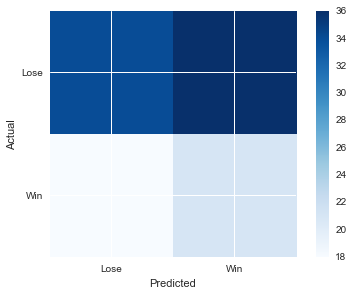

In [66]:
#random forest regressor
from sklearn.ensemble import RandomForestClassifier
randf2 = RandomForestClassifier()
randf2 = clf.fit(X_train, y_train)

#predict
y_predicted = randf2.predict(X_test)
y_predicted_proba = randf2.predict_proba(X_test)

print 'decision tree accuracy(train): ', randf2.score(X_train, y_train)
print 'decision accuracy(test): ', randf2.score(X_test,y_test)
print '====== Parameters analysis ========'
for x,y in sorted(zip(X_train.columns, map(lambda x: round(x, 4), randf2.feature_importances_)), 
             reverse=True,key=lambda tup: tup[1]):
    print '%s\t%.4f' % (x, y)
print '==== validation ====='
plot_c_matrix(y_predicted, y_test)

In [70]:
#save model for future use
from sklearn.externals import joblib
joblib.dump(clf, 'models/larh_decision_t.model')
joblib.dump(randf2, 'models/larh_random_forest.model')
joblib.dump(model, 'models/larh_logistic_reg.model')

['models/larh_logistic_reg.model',
 'models/larh_logistic_reg.model_01.npy',
 'models/larh_logistic_reg.model_02.npy',
 'models/larh_logistic_reg.model_03.npy']